# Лабораторна робота №2

#### Тема: Нейронна мережа із зворотнім поширенням похибки
#### Мета: Вивчити один із методів функціонування нейронних мереж і принципи його застосування

In [1]:
import numpy as np

Цільова функція має вигляд: 
$$f(x_1, x_2, x_3) = x_1^2 + \sin x_2^2 - \tan x_3$$

Датасет отримується шляхом обчислення значень функції в заданих значеннях аргументів $([7, 4, 5])$ та їх варіаціях з кроками $\pm 1$

In [2]:
def goal_func(x):
    return x[:, 0] ** 2 + np.sin(x[:, 1] ** 2) - np.tan(x[:, 2])

In [3]:
def initialize_data(initial_params):  
    x0 = np.array(initial_params)
    steps = [-1, 0, 1]
    X = np.array([x0 + [dx1, dx2, dx3] for dx1 in steps for dx2 in steps for dx3 in steps])
    np.random.shuffle(X)

    D1 = goal_func(X)
    d1_avg = np.mean(D1)
    D2 = [1 if d > d1_avg else 0 for d in D1]
    D = np.array([D1, D2]).T
    return X, D


def get_train_val_data(X, D):
    X_train, X_val = np.array(X)[:20, :], np.array(X)[20:, :]
    D_train, D_val = np.array(D)[:20, :], np.array(D)[20:, :]
    return X_train, D_train, X_val, D_val
    
    
X, D = initialize_data([7, 4, 5])
X_train, D_train, X_val, D_val = get_train_val_data(X, D)

In [4]:
print("(normalized values)")
print("Train data")
for x, d in zip(X_train, D_train):
    print(f"f{x}={d[0]:<.5f}; f(x) > _avg_: {int(d[1])}")
    
print("\nValidation data")
for x, d in zip(X_val, D_val):
    print(f"f{x}={d[0]:<.5f}; f(x) > _avg_: {int(d[1])}")

(normalized values)
Train data
f[7 4 6]=49.00310; f(x) > _avg_: 0
f[8 4 5]=67.09261; f(x) > _avg_: 1
f[7 5 5]=52.24816; f(x) > _avg_: 1
f[6 4 4]=34.55428; f(x) > _avg_: 0
f[8 3 5]=67.79263; f(x) > _avg_: 1
f[6 3 4]=35.25430; f(x) > _avg_: 0
f[6 3 5]=39.79263; f(x) > _avg_: 0
f[6 4 6]=36.00310; f(x) > _avg_: 0
f[8 3 4]=63.25430; f(x) > _avg_: 1
f[8 4 4]=62.55428; f(x) > _avg_: 1
f[6 5 4]=34.70983; f(x) > _avg_: 0
f[8 5 4]=62.70983; f(x) > _avg_: 1
f[7 3 4]=48.25430; f(x) > _avg_: 0
f[7 3 6]=49.70312; f(x) > _avg_: 0
f[7 5 4]=47.70983; f(x) > _avg_: 0
f[6 5 6]=36.15865; f(x) > _avg_: 0
f[6 4 5]=39.09261; f(x) > _avg_: 0
f[7 4 5]=52.09261; f(x) > _avg_: 1
f[7 5 6]=49.15865; f(x) > _avg_: 0
f[8 4 6]=64.00310; f(x) > _avg_: 1

Validation data
f[8 5 5]=67.24816; f(x) > _avg_: 1
f[6 5 5]=39.24816; f(x) > _avg_: 0
f[8 5 6]=64.15865; f(x) > _avg_: 1
f[6 3 6]=36.70312; f(x) > _avg_: 0
f[7 3 5]=52.79263; f(x) > _avg_: 1
f[8 3 6]=64.70312; f(x) > _avg_: 1
f[7 4 4]=47.55428; f(x) > _avg_: 0


### Архітектура нейронної мережі


<img src="images/densenn.png" width=300 height=300 />

Кількість нейронів у прихованому шарі буде змінна (3, 10, 25)

Алгоритм начання мережі можна поділити на декілька етапів:
- Feed forward
<img src="images/forward.png" width=300 height=300  />
- Backpropagation
<img src="images/cost.png" width=300 height=300 />
<img src="images/back.png" width=500 height=500 />
- Update of weights


In [5]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
MAX_EPOCH = 30000


def sigmoid(x, derivative=False):
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1. / (1 + np.exp(-x))


class Dense_NN:
    def __init__(self, dims=[3, 3, 2], activation=sigmoid):
        ''' NN Parameters initialization
        It is generally recommended to have weights uniformly distributed 
        while bias weights are usually set equal to zeros at the beginning
        '''
        self.activation = activation
        self.dimensions = dims
        self.N = len(dims) - 1
        self.weights = []
        self.biases = []
        self.scaler = MinMaxScaler()
        
    def initialize(self):
        for i in range(len(self.dimensions)-1):
            p, l = self.dimensions[i:i+2]
            self.weights.append(np.random.uniform(-1, 1, (p, l)))
            self.biases.append(np.zeros((1, l)))
            
    def normalize(self, y):
        try:
            y = self.scaler.transform(y)
        except Exception:
            print("Please, train the model first")
            return
        return y
    
    def denormalize(self, y):
        try:
            y[:,1][y[:,1] > 0.5] = 1
            y[:,1][y[:,1] <= 0.5] = 0
            y = self.scaler.inverse_transform(y)
        except Exception:
            print("Please, train the model first")
            return
        return y
    
    def _loss(self, d, y):
        return 1. / 2 * np.sum((d - y)  ** 2) 
    
    def _shuffle_data(self, x, d):
        data = list(zip(x, d))
        np.random.shuffle(data)
        x, d = zip(*data)
        x, d = np.array(x), np.array(d)
        return x, d
    
    def _feedforward(self, x):
        cache = {}
        a = x
        cache["a0"] = a
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(a, W) + b
            a = sigmoid(z)
            cache["z"+str(i+1)] = z
            cache["a"+str(i+1)] = a
        return cache, a
    
    def _backpropagation(self, d, y, cache):
        n_samples = d.shape[0]
        z, a = cache["z"+str(self.N)], cache["a"+str(self.N-1)]
        delta = (y - d) * self.activation(z, derivative=True) 
        dW, db = [np.dot(a.T, delta) / n_samples], [np.sum(delta, axis=0) / n_samples]
        for i in range(self.N-1, 0, -1):
            z, a = cache["z"+str(i)], cache["a"+str(i-1)]
            delta = np.dot(delta, self.weights[i].T) * sigmoid(z, derivative=True)
            dW.insert(0, np.dot(a.T, delta) / n_samples)
            db.insert(0, np.sum(delta, axis=0) / n_samples)
        return dW, db
    
    def _update(self, learning_rate, dW, db):
        for i in range(self.N):
            self.weights[i] = self.weights[i] - learning_rate * dW[i] 
            self.biases[i] = self.biases[i] - learning_rate * db[i]
    
    def fit(self, X_train, D_train, X_val=None, D_val=None, learning_rate=0.2, epochs=MAX_EPOCH):
        self.initialize()
        if D_val is not None:
            self.scaler.fit(np.vstack([D_train, D_val]))
            D_train = self.normalize(D_train)  # first, scale output data to be able to use sigmoid
            D_val = self.normalize(D_val) 
        else:
            self.scaler.fit(D_train)
            D_train = self.normalize(D_train) 
        
        losses = {}
        for epoch in range(epochs+1):
            x, d = self._shuffle_data(X_train, D_train)
            
            cache, y = self._feedforward(x)  # forward
            dW, db = self._backpropagation(d, y, cache)  # backward
            self._update(learning_rate, dW, db)  # update
            
            # accuracy
            if not (epoch) % (epochs/10):
                losses[epoch] = {"train loss" : self._loss(d, y), "train_y": y}
                if D_val is not None:
                    _, y_val = self._feedforward(X_val)      
                    losses[epoch]["val loss"] = self._loss(D_val, y_val)
                    losses[epoch]["val_y"] = y_val
        return losses
                
    def evaluate(self, x):
        _, y = self._feedforward(x)
        y = self.denormalize(y)
        return y

Далі, за спеціальною пропозицією, буде наведено більш детальний розгляд точності алгоритму: які результати він видає для валідаційного сету на останній ітерації, при цьому розглядаються як нормалізовані дані, так і де-нормалізовані

Під час тренування мереж такі дії не виконуються в жодніх практиці, а дані, отримані в результаті прямого проходження по мережі і враховуються всі разом при обрахуванні помилки

In [18]:
nn = Dense_NN(dims=[3, 10, 2])
losses = nn.fit(X_train, D_train, X_val, D_val)

In [19]:
for epoch, loss in losses.items():
    print(f"Epoch {epoch:<5d}  Train: {loss['train loss']:<.6f}  Validation: {loss['val loss']:<.6f}")

Epoch 0      Train: 4.439049  Validation: 1.532625
Epoch 3000   Train: 1.647849  Validation: 0.771064
Epoch 6000   Train: 1.049495  Validation: 0.616156
Epoch 9000   Train: 0.857953  Validation: 0.641284
Epoch 12000  Train: 0.647402  Validation: 0.483447
Epoch 15000  Train: 0.489481  Validation: 0.352103
Epoch 18000  Train: 0.363786  Validation: 0.263858
Epoch 21000  Train: 0.255102  Validation: 0.210063
Epoch 24000  Train: 0.174251  Validation: 0.179968
Epoch 27000  Train: 0.134435  Validation: 0.164465
Epoch 30000  Train: 0.110267  Validation: 0.151577


#### Results of the last train epoch on validation set (normalised)

In [20]:
pred, d_norm = losses[MAX_EPOCH]["val_y"], nn.normalize(D_val)
for predicted, real in zip(pred, d_norm):
    print(
        f"feature 1: (model) {predicted[0]:<.5f} - {real[0]:<.5f} (real)    "
        f"feature 2: (model) {predicted[1]:<.5f} - {real[1]} (real)"
    )
loss = 1. / 2 * np.sum((pred - d_norm) ** 2, axis=0)
print(f"\nLoss on the 1-st feature: {loss[0]}\nLoss on the 2-nd feature: {loss[1]}")

feature 1: (model) 0.92099 - 0.98362 (real)    feature 2: (model) 0.99227 - 1.0 (real)
feature 1: (model) 0.06179 - 0.14122 (real)    feature 2: (model) 0.00200 - 0.0 (real)
feature 1: (model) 0.92728 - 0.89067 (real)    feature 2: (model) 0.99509 - 1.0 (real)
feature 1: (model) 0.10068 - 0.06465 (real)    feature 2: (model) 0.00064 - 0.0 (real)
feature 1: (model) 0.59632 - 0.54871 (real)    feature 2: (model) 0.65474 - 1.0 (real)
feature 1: (model) 0.93267 - 0.90705 (real)    feature 2: (model) 0.97893 - 1.0 (real)
feature 1: (model) 0.41083 - 0.39111 (real)    feature 2: (model) 0.40895 - 0.0 (real)

Loss on the 1-st feature: 0.008090480159380496
Loss on the 2-nd feature: 0.1434863021653156


#### Results of the last train epoch on validation set (denormalised)

In [21]:
pred_denorm = nn.denormalize(losses[MAX_EPOCH]["val_y"])
for predicted, real in zip(pred_denorm, D_val):
    print(
        f"feature 1: (model) {predicted[0]:<.5f} - {real[0]:<.5f} (real)    "
        f"feature 2: (model) {predicted[1]} - {real[1]} (real)"
    )
loss = 1. / 2 * np.sum((pred_denorm - D_val) ** 2, axis=0)
print(f"\nLoss on the 1-st feature: {loss[0]}\nLoss on the 2-nd feature: {loss[1]}")

feature 1: (model) 65.16645 - 67.24816 (real)    feature 2: (model) 1.0 - 1.0 (real)
feature 1: (model) 36.60804 - 39.24816 (real)    feature 2: (model) 0.0 - 0.0 (real)
feature 1: (model) 65.37542 - 64.15865 (real)    feature 2: (model) 1.0 - 1.0 (real)
feature 1: (model) 37.90065 - 36.70312 (real)    feature 2: (model) 0.0 - 0.0 (real)
feature 1: (model) 54.37490 - 52.79263 (real)    feature 2: (model) 1.0 - 1.0 (real)
feature 1: (model) 65.55473 - 64.70312 (real)    feature 2: (model) 1.0 - 1.0 (real)
feature 1: (model) 48.20954 - 47.55428 (real)    feature 2: (model) 0.0 - 0.0 (real)

Loss on the 1-st feature: 8.93826902332682
Loss on the 2-nd feature: 0.0


In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
import timeit

Дослідимо точність натренованої мережі при різних кількостях **прихованих нейронів**: 3, 10, 25

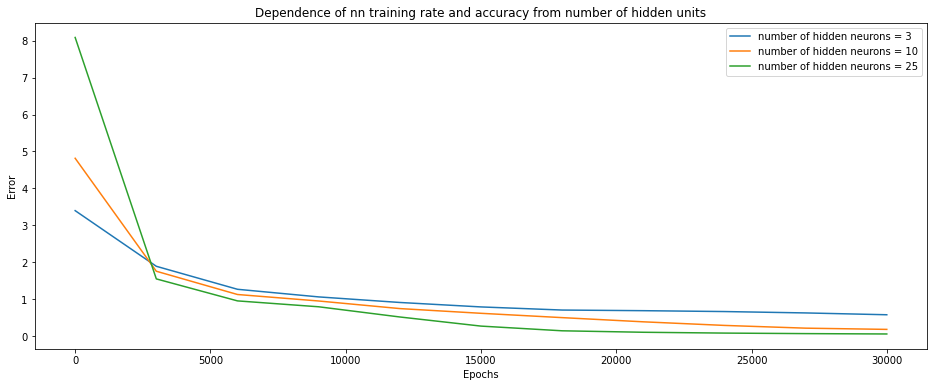

In [23]:
fig = plt.figure(figsize=(16, 6))
results ={}
n_hidden_neurons = [3, 10, 25]
for k in n_hidden_neurons:
    results[k] = {}
    start = timeit.default_timer()
    nn = Dense_NN(dims=[3, k, 2])
    res = nn.fit(X_train, D_train, X_val, D_val)
    results[k]["losses"] = {
        "epochs": list(res.keys()),
        "train": [value["train loss"] for value in res.values()],
        "validation": [value["val loss"] for value in res.values()]
    }
    results[k]["final val results"] = nn.denormalize(res[MAX_EPOCH]["val_y"])
    results[k]["time"] = timeit.default_timer() - start
    plt.plot(results[k]["losses"]["epochs"], results[k]["losses"]["train"], label="number of hidden neurons = " + str(k))
    
plt.title("Dependence of nn training rate and accuracy from number of hidden units")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.show()

In [24]:
print("Validation set\nTraining time and accuracy:")
for k in n_hidden_neurons:
    print(f"(k={k:<2d})  time: {results[k]['time']:<.6f}s  accuracy: {results[k]['losses']['validation'][-1]}")
print("\nTest set accuracy:")

print(" " * 30 , end="")
for k in n_hidden_neurons:
    print(f"| k = {k:<2d}" + " " * 11, end=" ")
print("\n" + "-" * 91)

for i in range(len(X_val)):
    print(f"x={X_val[i]} | f(x)=({D_val[i][0]:<.4f}, {int(D_val[i][1])})", end = " | ")
    for k in n_hidden_neurons:
        print(f"f(x)=({results[k]['final val results'][i][0]:<.4f}, " 
              f"{int(results[k]['final val results'][i][1])})", end=" | ")
    print()

Validation set
Training time and accuracy:
(k=3 )  time: 3.709392s  accuracy: 0.31727587552199554
(k=10)  time: 4.237535s  accuracy: 0.5843006674689653
(k=25)  time: 4.485739s  accuracy: 0.06047232627881505

Test set accuracy:
                              | k = 3             | k = 10            | k = 25            
-------------------------------------------------------------------------------------------
x=[8 5 5] | f(x)=(67.2482, 1) | f(x)=(65.0817, 1) | f(x)=(66.5493, 1) | f(x)=(65.3170, 1) | 
x=[6 5 5] | f(x)=(39.2482, 0) | f(x)=(36.9833, 0) | f(x)=(37.2736, 0) | f(x)=(37.4419, 0) | 
x=[8 5 6] | f(x)=(64.1587, 1) | f(x)=(63.9484, 1) | f(x)=(65.4949, 1) | f(x)=(64.5649, 1) | 
x=[6 3 6] | f(x)=(36.7031, 0) | f(x)=(38.6904, 0) | f(x)=(39.4929, 0) | f(x)=(38.3756, 0) | 
x=[7 3 5] | f(x)=(52.7926, 1) | f(x)=(49.7807, 0) | f(x)=(53.7665, 0) | f(x)=(52.0700, 1) | 
x=[8 3 6] | f(x)=(64.7031, 1) | f(x)=(60.8943, 1) | f(x)=(61.2064, 1) | f(x)=(63.3123, 1) | 
x=[7 4 4] | f(x)=(47.5543, 0) | 

Дослідимо точність натренованої мережі при трьох різних значеннях **learning rate**: 0.05, 0.2, 0.5

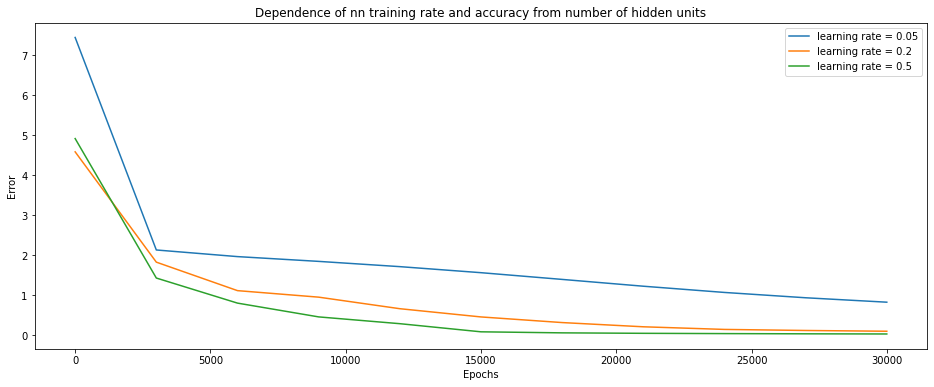

In [25]:
fig = plt.figure(figsize=(16, 6))
test_results = []
time = []
results ={}
learning_rates = [0.05, 0.2, 0.5]
for lr in learning_rates:
    results[lr] = {}
    start = timeit.default_timer()
    nn = Dense_NN(dims=[3, 10, 2])
    res = nn.fit(X_train, D_train, X_val, D_val, learning_rate=lr)
    results[lr]["losses"] = {
        "epochs": list(res.keys()),
        "train": [value["train loss"] for value in res.values()],
        "validation": [value["val loss"] for value in res.values()]
    }
    results[lr]["final val results"] = nn.denormalize(res[MAX_EPOCH]["val_y"])
    results[lr]["time"] = timeit.default_timer() - start
    plt.plot(results[lr]["losses"]["epochs"], results[lr]["losses"]["train"], label="learning rate = " + str(lr))
    
plt.title("Dependence of nn training rate and accuracy from number of hidden units")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.show()

In [26]:
print("Validation set\nTraining time and accuracy:")
for lr in learning_rates:
    print(f"(lr={lr:<.2f})  time: {results[lr]['time']:<.6f}s  accuracy: {results[lr]['losses']['validation'][-1]}")
print("\nTest set accuracy:")

print(" " * 10 + "|" + " " * 19 , end="")
for lr in learning_rates:
    print(f"| lr = {lr:<.2f}" + " " * 8, end=" ")
print("\n" + "-" * 91)
    
for i in range(len(X_val)):
    print(f"x={X_val[i]} | f(x)=({D_val[i][0]:<.4f}, {int(D_val[i][1])})", end = " | ")
    for lr in learning_rates:
        print(f"f(x)=({results[lr]['final val results'][i][0]:<.4f}, " 
              f"{int(results[lr]['final val results'][i][1])})", end=" | ")
    print()

Validation set
Training time and accuracy:
(lr=0.05)  time: 4.441562s  accuracy: 0.46297674164444425
(lr=0.20)  time: 4.122742s  accuracy: 0.17356122198300059
(lr=0.50)  time: 4.005227s  accuracy: 0.05879433965275063

Test set accuracy:
          |                   | lr = 0.05         | lr = 0.20         | lr = 0.50         
-------------------------------------------------------------------------------------------
x=[8 5 5] | f(x)=(67.2482, 1) | f(x)=(60.2577, 1) | f(x)=(65.0322, 1) | f(x)=(64.9071, 1) | 
x=[6 5 5] | f(x)=(39.2482, 0) | f(x)=(38.6701, 0) | f(x)=(36.2434, 0) | f(x)=(37.2559, 0) | 
x=[8 5 6] | f(x)=(64.1587, 1) | f(x)=(60.5183, 1) | f(x)=(64.6439, 1) | f(x)=(63.6393, 1) | 
x=[6 3 6] | f(x)=(36.7031, 0) | f(x)=(39.2109, 0) | f(x)=(37.6813, 0) | f(x)=(37.5946, 0) | 
x=[7 3 5] | f(x)=(52.7926, 1) | f(x)=(52.9995, 0) | f(x)=(53.7142, 1) | f(x)=(53.7578, 1) | 
x=[8 3 6] | f(x)=(64.7031, 1) | f(x)=(60.1250, 1) | f(x)=(65.1193, 1) | f(x)=(64.5644, 1) | 
x=[7 4 4] | f(x)=(47.5